# Fully operational 2D tracking of the inertial particle settling through a TNTI using OpenPTV-Python

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import os
from tqdm import tqdm 

In [18]:
# read parameters
from openptv_python.parameters import (
    read_control_par,
    read_sequence_par,
    read_track_par,
    read_volume_par
)
from openptv_python.calibration import read_calibration
from openptv_python.track import (
    track_forward_start,
    trackback_c,
    trackcorr_c_finish,
    trackcorr_c_loop,
)
from openptv_python.tracking_run import tr_new
from openptv_python.image_processing import prepare_image

from openptv_python.parameters import TargetPar
from openptv_python.segmentation import target_recognition
from openptv_python.tracking_frame_buf import write_targets


In [19]:
# working directory
exp_dir = Path('/home/user/Downloads/test_crossing_particle')
os.chdir(exp_dir)
os.listdir('.')
# os.listdir(exp_dir)

['test_openptv_python_crossing_particle',
 'parameters',
 'cal',
 'img',
 'notebooks',
 'res',
 'C001H001S0005 (copy)']

In [20]:

parameters_dir = 'parameters'
os.listdir(parameters_dir)


['multi_planes.par',
 'criteria.par',
 'pft_version',
 'track.par',
 'detect_plate.par',
 'sequence.par',
 'shaking.par',
 'man_ori.par',
 'orient.par',
 'targ_rec.par',
 'examine.par',
 'cal_ori.par',
 'unsharp_mask.par',
 'ptv.par',
 'pft_version.par',
 'dumbbell.par',
 'man_ori.dat',
 'sortgrid.par']

In [21]:
cpar = read_control_par(os.path.join(parameters_dir,'ptv.par'))
print(cpar)

ControlPar(num_cams=1, img_base_name=['img/C001H001S0005000001.tif'], cal_img_base_name=['cal/cam1.tif'], hp_flag=1, all_cam_flag=0, tiff_flag=1, imx=1024, imy=1024, pix_x=0.001, pix_y=0.001, chfield=0, mm=MultimediaPar(nlay=1, n1=1.0, n2=[1.0], d=[1.0], n3=1.0))


In [22]:
ori_file =  'cal/cam1.tif.ori'
addpar_file = 'cal/cam1.tif.addpar'
cal = [read_calibration(ori_file, addpar_file)]
print(cal)

[Calibration(ext_par=Exterior: x0=0.0, y0=0.0, z0=100.0
omega=0.0, phi=0.0, kappa=0.0
, int_par=Interior(xh=0.0, yh=0.0, cc=100.0), glass_par=Glass(vec_x=0.0, vec_y=0.0, vec_z=1.0), added_par=ap_52(k1=0.0, k2=0.0, k3=0.0, p1=0.0, p2=0.0, scx=1.0, she=0.0), mmlut=mm_lut(origin=array([0., 0., 0.]), nr=0, nz=0, rw=0, data=None))]


In [23]:

seq_par_fname = "parameters/sequence.par"
tpar_fname = "parameters/track.par"
vpar_fname = "parameters/criteria.par"
cpar_fname = "parameters/ptv.par"

seq_par = read_sequence_par(seq_par_fname, cpar.num_cams)
tpar = read_track_par(tpar_fname)
vpar = read_volume_par(vpar_fname)

print(seq_par)
print(tpar)
print(vpar)

SequencePar(img_base_name=['img/C001H001S0005%06d.tif'], first=248, last=253)
TrackPar(dvxmin=-15.5, dvxmax=15.5, dvymin=-15.5, dvymax=15.5, dvzmin=-15.5, dvzmax=15.5, dangle=120.0, dacc=5.5, add=1, dsumg=0.0, dn=0.0, dnx=0.0, dny=0.0)
VolumePar(x_lay=[-40.0, 40.0], z_min_lay=[-20.0, -20.0], z_max_lay=[20.0, 20.0], cn=0.02, cnx=0.02, cny=0.02, csumg=0.02, eps0=0.05, corrmin=33.0)


img/C001H001S0005000001.tif


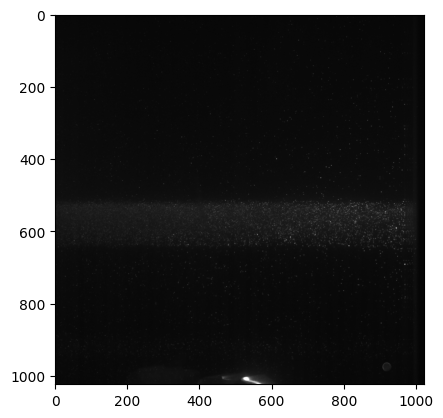

In [24]:
# image segmentation
frame_num = 1
cam_num = 0
img_name = seq_par.img_base_name[cam_num] % frame_num
print(img_name)
img = mpimg.imread(img_name)
plt.imshow(img, cmap='gray')

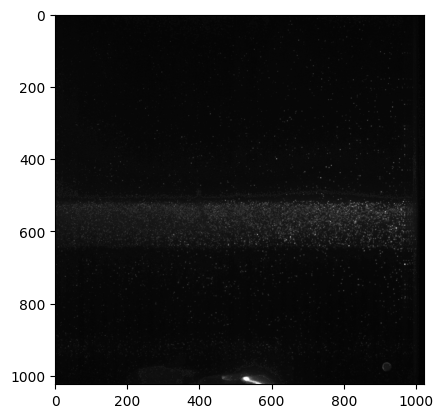

In [25]:
# prepare image for detection
  
img_hp = prepare_image(img, 1, 0)
plt.imshow(img_hp, cmap='gray')

In [26]:
# detection

tpar = TargetPar(
    gvthresh=[20, 255, 255, 255],
    discont=5,
    nnmin=1,
    nnmax=10,
    sumg_min=12,
    nxmin=1,
    nxmax=10,
    nymin=1,
    nymax=10,
)

target_array = target_recognition(img, tpar, 0, cpar)

print(len(target_array))
print(target_array[0].count_pixels())

4126
(1, 1, 1)


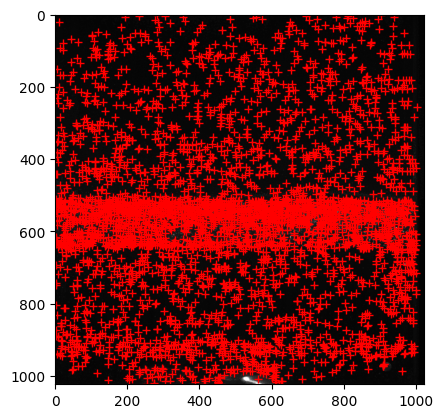

In [27]:
plt.imshow(img_hp, cmap='gray')
for target in target_array:
    plt.plot(target.x, target.y, 'r+')

In [28]:
# Test single writing
write_targets(target_array, len(target_array), img_name, 0)

True

In [29]:
# create all the targets in the loop
for frame_num in tqdm(range(seq_par.first, seq_par.last + 1)):
    for cam_num in range(cpar.num_cams):
        img_name = seq_par.img_base_name[cam_num] % frame_num
        img = mpimg.imread(img_name)
        img_hp = prepare_image(img, 1, 0)
        target_array = target_recognition(img, tpar, 0, cpar)
        write_targets(target_array, len(target_array), img_name, 0)

100%|██████████| 6/6 [00:25<00:00,  4.32s/it]


In [32]:
run = tr_new(
            seq_par_fname,
            tpar_fname,
            vpar_fname,
            cpar_fname,
            4,
            20000,
            "res/rt_is",
            "res/ptv_is",
            "res/added",
            cal,
            10000.0,
)

run.tpar.add = 0
print(f"run.seq_par.first = {run.seq_par.first} run.seq_par.last = {run.seq_par.last}")

track_forward_start(run)


run.seq_par.first = 248 run.seq_par.last = 253
 filename: img/C001H001S0005000248.tif_targets
 filename: img/C001H001S0005000249.tif_targets
 filename: img/C001H001S0005000250.tif_targets


In [33]:
trackcorr_c_loop(run, run.seq_par.first)

for step in range(run.seq_par.first + 1, run.seq_par.last):
    # print(f"step = {step}")
    trackcorr_c_loop(run, step)
    # print(f"run.npart = {run.npart}")
    # print(f"run.nlinks = {run.nlinks}")

trackcorr_c_finish(run, run.seq_par.last)


range_val = run.seq_par.last - run.seq_par.first
npart = run.npart / range_val
nlinks = run.nlinks / range_val


step: 248, curr: 0, next_frame: 0,             links: 0, lost: 0, add: 0
 filename: img/C001H001S0005000251.tif_targets
step: 249, curr: 0, next_frame: 0,             links: 0, lost: 0, add: 0
 filename: img/C001H001S0005000252.tif_targets
step: 250, curr: 0, next_frame: 0,             links: 0, lost: 0, add: 0
 filename: img/C001H001S0005000253.tif_targets
step: 251, curr: 0, next_frame: 0,             links: 0, lost: 0, add: 0
step: 252, curr: 0, next_frame: 0,             links: 0, lost: 0, add: 0
Average over sequence, particles: 0.0, links: 0.0, lost: 0.0
